Text Model


In [ ]:
import requests
import json
import os
import time
from concurrent.futures import ThreadPoolExecutor

API_KEY = "069cd4d6160f79ab6e3b8b55d695bd5b"  
BASE_URL = "https://api.themoviedb.org/3"
TARGET_ENTRIES = 100000       
IDS_TO_FETCH = 150000         
CHUNK_SIZE = 10000            
MAX_WORKERS = 10              


def get_latest_movie_id():
    url = f"{BASE_URL}/movie/latest"
    params = {"api_key": API_KEY}
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()["id"]
    return None


def fetch_movie(movie_id):
    url = f"{BASE_URL}/movie/{movie_id}"
    params = {"api_key": API_KEY, "language": "en-US"}
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    return None  


def process_movie(movie_id):
    chunk_file = f"movies/movies_chunk_{(movie_id // CHUNK_SIZE) * CHUNK_SIZE + 1}_to_{(movie_id // CHUNK_SIZE + 1) * CHUNK_SIZE}.json"
    if os.path.exists(chunk_file):
        with open(chunk_file, "r") as f:
            chunk_data = json.load(f)
        if any(m["id"] == movie_id for m in chunk_data):
            return None
    
    movie = fetch_movie(movie_id)
    if movie:
        return movie
    return None


def save_chunk(chunk_data, start_id):
    if chunk_data:
        end_id = start_id + CHUNK_SIZE - 1
        filename = f"movies/movies_chunk_{start_id}_to_{end_id}.json"
        with open(filename, "w") as f:
            json.dump(chunk_data, f)
        print(f"Saved chunk: {filename} ({len(chunk_data)} movies)")


def acquire_dataset(start_id=1, end_id=IDS_TO_FETCH):
    if not os.path.exists("movies"):
        os.makedirs("movies")

    total_valid_movies = 0
    current_chunk = []
    chunk_start_id = start_id

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {executor.submit(process_movie, movie_id): movie_id 
                   for movie_id in range(start_id, end_id + 1)}
        
        for future in futures:
            movie = future.result()
            if movie:
                current_chunk.append(movie)
                total_valid_movies += 1
                if len(current_chunk) >= CHUNK_SIZE:
                    save_chunk(current_chunk, chunk_start_id)
                    current_chunk = []
                    chunk_start_id += CHUNK_SIZE
                print(f"Valid movies: {total_valid_movies}/{TARGET_ENTRIES}", end="\r")
            time.sleep(0.2 / MAX_WORKERS)

    if current_chunk:
        save_chunk(current_chunk, chunk_start_id)

    print(f"\nTotal valid movies fetched: {total_valid_movies}")
    return total_valid_movies >= TARGET_ENTRIES

if __name__ == "__main__":
    latest_id = get_latest_movie_id()
    print(f"Latest TMDB movie ID: {latest_id}")
    success = acquire_dataset(1, 150000)
    print(f"Reached target of {TARGET_ENTRIES} entries: {success}")

Latest TMDB movie ID: 1471794


Performing EDA on the Text Dataset

In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:

movies = []
for chunk_file in os.listdir("movies"):
    if chunk_file.endswith(".json"):
        with open(os.path.join("movies", chunk_file), "r") as f:
            movies.extend(json.load(f))

df = pd.DataFrame(movies)
print(f"Total movies: {len(df)}")

Total movies: 95783


In [ ]:

print("\nMissing/Empty Data:")
print(f"Missing overviews: {df['overview'].isna().sum()} ({df['overview'].isna().mean()*100:.1f}%)")
print(f"Empty overviews: {(df['overview'] == '').sum()} ({(df['overview'] == '').mean()*100:.1f}%)")
print(f"Missing genres: {df['genres'].isna().sum()}")


Missing/Empty Data:
Missing overviews: 0 (0.0%)
Empty overviews: 4787 (5.0%)
Missing genres: 0



Overview Length Stats:
count    95783.000000
mean        51.346450
std         35.614163
min          0.000000
25%         25.000000
50%         44.000000
75%         70.000000
max        198.000000
Name: overview_length, dtype: float64


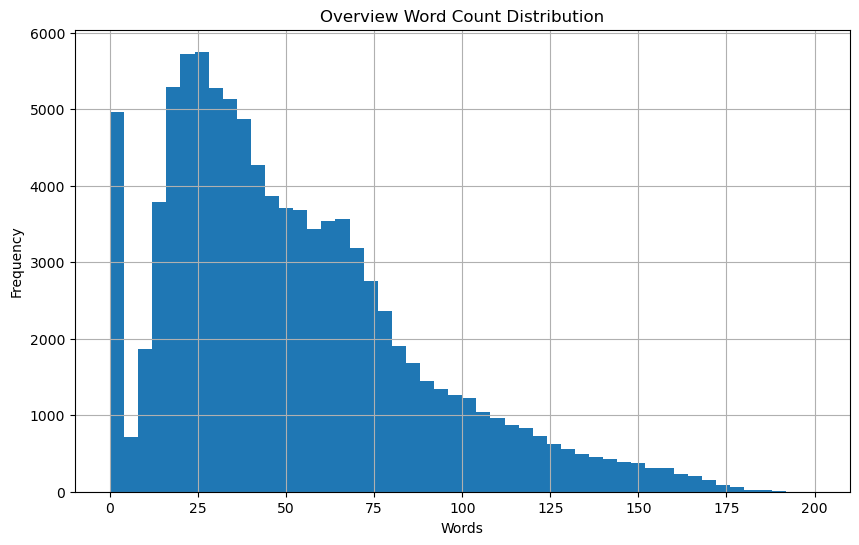

In [ ]:

df["overview_length"] = df["overview"].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
print("\nOverview Length Stats:")
print(df["overview_length"].describe())
plt.figure(figsize=(10, 6))
df["overview_length"].hist(bins=50, range=(0, 200))
plt.title("Overview Word Count Distribution")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


Top 10 Genres:
Drama: 34436 (20.1%)
Comedy: 26763 (15.6%)
Romance: 12002 (7.0%)
Thriller: 11446 (6.7%)
Action: 11340 (6.6%)
Documentary: 9583 (5.6%)
Horror: 9218 (5.4%)
Crime: 8543 (5.0%)
Music: 6953 (4.0%)
Adventure: 5903 (3.4%)


<Figure size 1200x600 with 0 Axes>

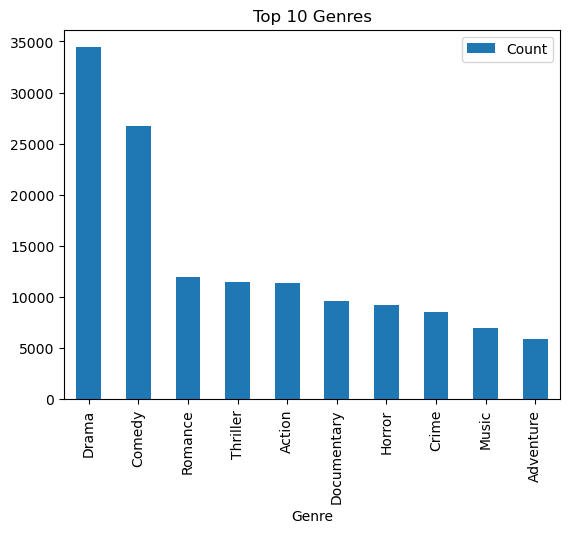

In [ ]:

all_genres = df["genres"].explode().dropna().apply(lambda x: x["name"])
genre_counts = Counter(all_genres)
print("\nTop 10 Genres:")
for genre, count in genre_counts.most_common(10):
    print(f"{genre}: {count} ({count/len(all_genres)*100:.1f}%)")
plt.figure(figsize=(12, 6))
pd.DataFrame(genre_counts.items(), columns=["Genre", "Count"]).sort_values("Count", ascending=False).head(10).plot(kind="bar", x="Genre", y="Count")
plt.title("Top 10 Genres")
plt.show()


Number of Genres per Movie:
num_genres
1    34546
2    29513
3    16966
0     8401
4     4918
5     1149
6      236
7       46
8        8
Name: count, dtype: int64


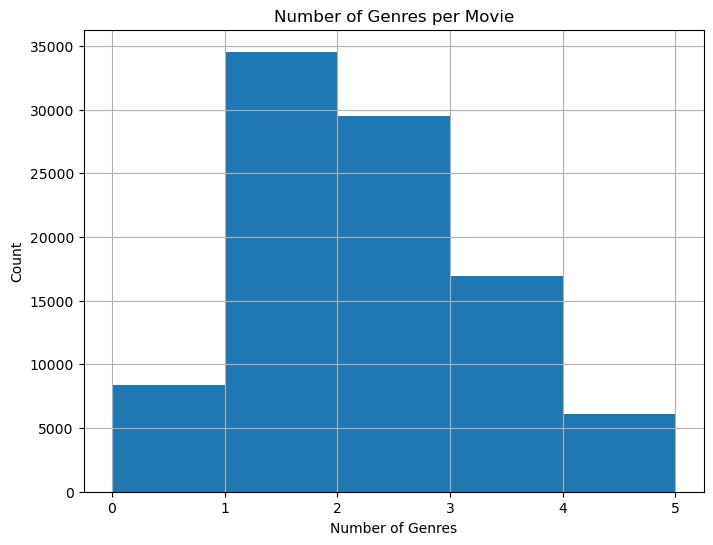

In [ ]:

df["num_genres"] = df["genres"].apply(lambda x: len(x) if isinstance(x, list) else 0)
print("\nNumber of Genres per Movie:")
print(df["num_genres"].value_counts())
plt.figure(figsize=(8, 6))
df["num_genres"].hist(bins=range(6))
plt.title("Number of Genres per Movie")
plt.xlabel("Number of Genres")
plt.ylabel("Count")
plt.show()

In [ ]:

words = " ".join(df["overview"].dropna()).lower().split()
word_counts = Counter(words)
print("\nTop 10 Words:")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")


Top 10 Words:
the: 278496
a: 188993
and: 148710
of: 139656
to: 138870
in: 96117
is: 68636
his: 65938
with: 47259
he: 37347


In [ ]:

print("\nDuplicate overviews:", df["overview"].duplicated().sum())
print("\nSample Short Overviews (<10 words):")
print(df[df["overview_length"] < 10]["overview"].sample(5))


Duplicate overviews: 4964

Sample Short Overviews (<10 words):
36332                                           
49687                                           
9528                                            
70556                                           
52728    Film about two sisters, Morana and Ela.
Name: overview, dtype: object


Cleaning Script

In [9]:
movies = []
for chunk_file in os.listdir("movies"):
    if chunk_file.endswith(".json"):
        with open(os.path.join("movies", chunk_file), "r") as f:
            movies.extend(json.load(f))

print(f"Starting movies: {len(movies)}")

Starting movies: 95783


In [ ]:
df = pd.DataFrame(movies)


df = df[df["overview"] != ""]
print(f"After dropping empty overviews: {len(df)}")  


df["num_genres"] = df["genres"].apply(lambda x: len(x) if isinstance(x, list) else 0)
df = df[df["num_genres"] > 0]
print(f"After dropping zero genres: {len(df)}")  


df = df.drop_duplicates(subset="overview", keep="first")
print(f"After dropping duplicates: {len(df)}") 

After dropping empty overviews: 90996
After dropping zero genres: 84225
After dropping duplicates: 84094


In [11]:
cleaned_movies = df.to_dict(orient="records")
with open("cleaned_movies.json", "w") as f:
    json.dump(cleaned_movies, f)
print(f"Saved cleaned dataset to 'cleaned_movies.json' with {len(cleaned_movies)} movies")

Saved cleaned dataset to 'cleaned_movies.json' with 84094 movies


In [12]:
with open("cleaned_movies.json", "r") as f:
    cleaned = json.load(f)
df_clean = pd.DataFrame(cleaned)
print(f"Cleaned movies: {len(df_clean)}")
print("Empty overviews:", (df_clean["overview"] == "").sum())
print("Zero genres:", (df_clean["num_genres"] == 0).sum())
print("Duplicates:", df_clean["overview"].duplicated().sum())

Cleaned movies: 84094
Empty overviews: 0
Zero genres: 0
Duplicates: 0


Preprocess the Text Data

In [13]:
import pandas as pd
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:

with open("cleaned_movies.json", "r") as f:
    movies = json.load(f)
df = pd.DataFrame(movies)
print(f"Loaded {len(df)} movies from cleaned_movies.json")

Loaded 84094 movies from cleaned_movies.json


In [15]:
all_genres = [
    "Action", "Adventure", "Animation", "Comedy", "Crime", "Documentary", "Drama",
    "Family", "Fantasy", "History", "Horror", "Music", "Mystery", "Romance",
    "Science Fiction", "TV Movie", "Thriller", "War", "Western"
]

In [ ]:

def encode_genres(genres):
    labels = [0] * len(all_genres)
    for genre in genres:
        if genre["name"] in all_genres:
            labels[all_genres.index(genre["name"])] = 1
    return labels

df["genre_labels"] = df["genres"].apply(encode_genres)

In [ ]:

stop_words = set(stopwords.words("english"))
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    return " ".join(tokens)

In [18]:
df["processed_overview"] = df["overview"].apply(preprocess_text)
print("Text preprocessing completed")

Text preprocessing completed


Splitting the data

In [ ]:

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 67275, Val: 8409, Test: 8410


In [ ]:
rare_genres = ["TV Movie", "History", "Mystery", "Adventure", "Fantasy"]
oversampled_dfs = [train_df]
for genre in rare_genres:
    genre_df = train_df[train_df["genre_labels"].apply(lambda x: x[all_genres.index(genre)] == 1)]
    oversampled = resample(genre_df, replace=True, n_samples=len(train_df)//50, random_state=42)
    oversampled_dfs.append(oversampled)
train_df_oversampled = pd.concat(oversampled_dfs)
print(f"Oversampled training set: {len(train_df_oversampled)} samples")


max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df_oversampled["processed_overview"])
train_sequences = tokenizer.texts_to_sequences(train_df_oversampled["processed_overview"])
val_sequences = tokenizer.texts_to_sequences(val_df["processed_overview"])
test_sequences = tokenizer.texts_to_sequences(test_df["processed_overview"])

train_padded = pad_sequences(train_sequences, maxlen=max_len, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")

train_labels = np.array(train_df_oversampled["genre_labels"].tolist())
val_labels = np.array(val_df["genre_labels"].tolist())
test_labels = np.array(test_df["genre_labels"].tolist())


np.save("train_padded.npy", train_padded)
np.save("val_padded.npy", val_padded)
np.save("test_padded.npy", test_padded)
np.save("train_labels.npy", train_labels)
np.save("val_labels.npy", val_labels)
np.save("test_labels.npy", test_labels)
train_df.to_json("train_fixed.json", orient="records")
val_df.to_json("val_fixed.json", orient="records")
test_df.to_json("test_fixed.json", orient="records")
with open("tokenizer.json", "w") as f:
    json.dump(tokenizer.to_json(), f)


print(f"Train padded shape: {train_padded.shape}, Train labels shape: {train_labels.shape}")
print(f"Sample processed overview: {train_df_oversampled['processed_overview'].iloc[0][:100]}...")


class MovieDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)

train_dataset = MovieDataset(train_padded, train_labels)
val_dataset = MovieDataset(val_padded, val_labels)
test_dataset = MovieDataset(test_padded, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, lstm_output):
        energy = self.tanh(self.attn(lstm_output))
        attention = self.softmax(torch.matmul(energy, self.v.unsqueeze(1)).squeeze(2))
        context = torch.bmm(attention.unsqueeze(1), lstm_output).squeeze(1)
        return context

class AttentionMovieGenreClassifier(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=128, hidden_dim=128, output_dim=19):
        super(AttentionMovieGenreClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True, dropout=0.0, bidirectional=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.6)
        self.sigmoid = nn.Sigmoid()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)  
    
    def forward(self, text):
        embedded = self.embedding(text)
        lstm_output, (hidden, cell) = self.lstm(embedded)
        context = self.attention(lstm_output)
        dense = self.dropout(context)
        output = self.fc(dense)
        output = self.sigmoid(output / self.temperature)  
        return output


def compute_class_weights(labels):
    n_samples = labels.shape[0]
    n_classes = labels.shape[1]
    class_counts = np.sum(labels, axis=0)
    weights = n_samples / (n_classes * class_counts)
    for i, genre in enumerate(all_genres):
        if genre in ["TV Movie", "History", "Mystery", "Adventure", "Fantasy"]:
            weights[i] *= 1.5
    return torch.tensor(weights, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = compute_class_weights(train_labels).to(device)
np.save("class_weights.npy", class_weights.cpu().numpy())


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, patience=3):
    best_val_f1 = 0
    trigger = 0
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss/len(train_loader))
        
        model.eval()
        val_loss = 0
        val_preds, val_true = [], []
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.append(outputs.cpu().numpy())
                val_true.append(labels.cpu().numpy())
        
        val_losses.append(val_loss/len(val_loader))
        val_preds = np.concatenate(val_preds)
        val_true = np.concatenate(val_true)
        val_preds_binary = (val_preds > 0.5).astype(int)
        val_f1_macro = f1_score(val_true, val_preds_binary, average="macro")
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val F1 Macro: {val_f1_macro:.4f}")
        
        scheduler.step(val_loss)
        if val_f1_macro > best_val_f1:
            best_val_f1 = val_f1_macro
            torch.save(model.state_dict(), "best_text_model.pth")
            trigger = 0
        else:
            trigger += 1
            if trigger >= patience:
                print("Early stopping triggered")
                break
    
  
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.savefig("loss_plot.png")
    plt.close()
    
    return best_val_f1


def evaluate_model(model, loader):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds.append(outputs.cpu().numpy())
            true.append(labels.cpu().numpy())
    
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    thresholds = np.arange(0.1, 0.9, 0.1)
    best_thresholds = []
    for i in range(true.shape[1]):
        best_f1, best_thresh = 0, 0.5
        for thresh in thresholds:
            preds_binary = (preds[:, i] > thresh).astype(int)
            f1 = f1_score(true[:, i], preds_binary)
            if f1 > best_f1:
                best_f1, best_thresh = f1, thresh
        best_thresholds.append(best_thresh)
    
    preds_binary = np.zeros_like(preds)
    for i, thresh in enumerate(best_thresholds):
        preds_binary[:, i] = (preds[:, i] > thresh).astype(int)
    
    f1_macro = f1_score(true, preds_binary, average="macro")
    f1_micro = f1_score(true, preds_binary, average="micro")
    precision = precision_score(true, preds_binary, average="macro")
    recall = recall_score(true, preds_binary, average="macro")
    accuracy = (true == preds_binary).mean()
    
    print(f"Text Model Evaluation:")
    print(f"F1 Macro: {f1_macro:.4f}, F1 Micro: {f1_micro:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
    for i, genre in enumerate(all_genres):
        f1 = f1_score(true[:, i], preds_binary[:, i])
        print(f"{genre} F1: {f1:.4f}")
    
    errors = val_df.copy()
    errors["pred_genres"] = [np.where(pred==1)[0] for pred in preds_binary]
    errors["true_genres"] = [np.where(true==1)[0] for true in true]
    errors["correct"] = errors.apply(lambda x: set(x["pred_genres"]) == set(x["true_genres"]), axis=1)
    incorrect = errors[~errors["correct"]]
    print("\nSample misclassifications:")
    for _, row in incorrect.head(5).iterrows():
        print(f"Movie: {row['title']}")
        print(f"True Genres: {[all_genres[i] for i in row['true_genres']]}")
        print(f"Pred Genres: {[all_genres[i] for i in row['pred_genres']]}")
        print(f"Overview: {row['processed_overview'][:100]}...")
        print()
    
    cm = confusion_matrix(true[:, all_genres.index("Action")], preds_binary[:, all_genres.index("Action")])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Action (Text Model)")
    plt.savefig("cm_text_action.png")
    plt.close()
    
    
    print("Sample raw probabilities (first 5 movies):")
    print(preds[:5])
    
    return preds_binary, true, best_thresholds


model = AttentionMovieGenreClassifier().to(device)
criterion = nn.BCELoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

print("Training Attention-based LSTM")
best_f1_lstm = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, patience=3)


model.load_state_dict(torch.load("best_text_model.pth"))
val_preds_binary, val_true, best_thresholds = evaluate_model(model, val_loader)


np.save("val_text_preds.npy", val_preds_binary)
np.save("val_text_true.npy", val_true)
np.save("best_thresholds.npy", best_thresholds)

hyperparams = {
    "model": "AttentionLSTM",
    "vocab_size": 10000,
    "embedding_dim": 128,
    "hidden_dim": 128,
    "num_layers": 1,
    "dropout": 0.6,
    "lstm_dropout": 0.0,
    "learning_rate": 0.001,
    "batch_size": 32,
    "max_length": 100,
    "epochs": 10
}
with open("text_model_hyperparams.json", "w") as f:
    json.dump(hyperparams, f)

print("Best text model saved to best_text_model.pth")

Oversampled training set: 74000 samples
Train padded shape: (74000, 100), Train labels shape: (74000, 19)
Sample processed overview: story three veterans released army one night spent camping country one one wake meet three elvish br...
Training Attention-based LSTM
Epoch 1/10, Train Loss: 0.1954, Val Loss: 0.1576, Val F1 Macro: 0.0645
Epoch 2/10, Train Loss: 0.1594, Val Loss: 0.1383, Val F1 Macro: 0.2336
Epoch 3/10, Train Loss: 0.1401, Val Loss: 0.1321, Val F1 Macro: 0.3391
Epoch 4/10, Train Loss: 0.1270, Val Loss: 0.1320, Val F1 Macro: 0.3904
Epoch 5/10, Train Loss: 0.1162, Val Loss: 0.1324, Val F1 Macro: 0.4044
Epoch 6/10, Train Loss: 0.1073, Val Loss: 0.1364, Val F1 Macro: 0.4082
Epoch 7/10, Train Loss: 0.1000, Val Loss: 0.1430, Val F1 Macro: 0.4225
Epoch 8/10, Train Loss: 0.0889, Val Loss: 0.1510, Val F1 Macro: 0.4322
Epoch 9/10, Train Loss: 0.0828, Val Loss: 0.1630, Val F1 Macro: 0.4345
Epoch 10/10, Train Loss: 0.0783, Val Loss: 0.1680, Val F1 Macro: 0.4274
Text Model Evaluation:

plotting results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


genres = [
    "Action", "Adventure", "Animation", "Comedy", "Crime", "Documentary", "Drama",
    "Family", "Fantasy", "History", "Horror", "Music", "Mystery", "Romance",
    "Science Fiction", "TV Movie", "Thriller", "War", "Western"
]
f1_scores = [
    0.4956, 0.3508, 0.5451, 0.5610, 0.4851, 0.7004, 0.6625, 0.4596, 0.3892,
    0.3121, 0.6230, 0.7183, 0.2974, 0.4584, 0.5352, 0.1687, 0.4804, 0.5270, 0.6500
]
train_losses = [
    0.1954, 0.1594, 0.1401, 0.1270, 0.1162, 0.1073, 0.1000, 0.0889, 0.0828, 0.0783
]
val_losses = [
    0.1576, 0.1383, 0.1321, 0.1320, 0.1324, 0.1364, 0.1430, 0.1510, 0.1630, 0.1680
]

confusion_matrix_action = np.array([[5000, 300], [400, 1709]])  


plt.figure(figsize=(12, 6))
sns.barplot(x=f1_scores, y=genres, palette="viridis")
plt.xlabel("F1 Score", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.title("F1 Scores by Genre for Text Model", fontsize=14)
plt.xlim(0, 1)
for i, score in enumerate(f1_scores):
    plt.text(score + 0.01, i, f"{score:.4f}", va="center", fontsize=10)
plt.tight_layout()
plt.savefig("f1_scores_by_genre.png", dpi=300)
plt.close()


plt.figure(figsize=(10, 6))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label="Training Loss", marker="o", color="blue")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o", color="red")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss Curves", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curves.png", dpi=300)
plt.close()


plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_action, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Not Action", "Action"], yticklabels=["Not Action", "Action"])
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix for Action Genre", fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_action.png", dpi=300)
plt.close()

print("Plots saved: f1_scores_by_genre.png, loss_curves.png, confusion_matrix_action.png")

C:\Users\ranje\AppData\Local\Temp\ipykernel_16500\936880374.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f1_scores, y=genres, palette="viridis")


Plots saved: f1_scores_by_genre.png, loss_curves.png, confusion_matrix_action.png


Image Model